In [1]:
import tensorflow as tf
print(tf.__version__)

1.2.0


In [2]:
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

In [3]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
sess.close()

print(result)

42


In [4]:
with tf.Session() as sess:  # with a context
    x.initializer.run() # equivalent to tf.get_default_session().run(x.initializer)
    y.initializer.run()
    result = f.eval()

print(result)

42


In [5]:
init = tf.global_variables_initializer()

# prepare an init node
with tf.Session() as sess:
    init.run() # actually initialize all the variables
    result = f.eval()

print(result)

42


In [6]:
# preferable within the jupyter

sess = tf.InteractiveSession() # by doing this we avoid the need of a context
init.run()
result = f.eval()
print(result)
sess.close()

42


## Managing graphs

In [7]:
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [8]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)
print(x2.graph is graph)
print(x2.graph is tf.get_default_graph())

True
False


# Linear regression with Tensor flow
## With normal equation

In [9]:
import numpy as np
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [10]:
housing.keys()

dict_keys(['data', 'feature_names', 'DESCR', 'target'])

In [11]:
init = tf.global_variables_initializer()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT,X)),XT),y)

In [12]:
with tf.Session() as sess:
    init.run() # actually initialize all the variables
    theta_val = theta.eval()

In [13]:
theta_val

array([[ -3.74651413e+01],
       [  4.35734153e-01],
       [  9.33829229e-03],
       [ -1.06622010e-01],
       [  6.44106984e-01],
       [ -4.25131839e-06],
       [ -3.77322501e-03],
       [ -4.26648885e-01],
       [ -4.40514028e-01]], dtype=float32)

# gradient descent

In [18]:
tf.reset_default_graph() # clear the graph

n_epochs = 1000
learning_rate = eta = 0.01

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

inputs = n+1
outputs = 1

theta = tf.Variable(tf.random_uniform([inputs, outputs], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
#mse = tf.reduce_mean(tf.square(error), name="mse")
mse = tf.losses.mean_squared_error(y, y_pred)
gradients = 2 / m * tf.matmul(tf.transpose(X),error)
training_op = tf.assign(theta, theta - eta * gradients)

init = tf.global_variables_initializer() # need one again as we destroyed the graph

with tf.Session() as sess:
    sess.run(init) # actually initialize all the variables
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    theta_val = theta.eval()

Epoch 0 MSE = 6.34184
Epoch 100 MSE = 0.768376
Epoch 200 MSE = 0.656549
Epoch 300 MSE = 0.618457
Epoch 400 MSE = 0.592166
Epoch 500 MSE = 0.573255
Epoch 600 MSE = 0.559618
Epoch 700 MSE = 0.549781
Epoch 800 MSE = 0.542686
Epoch 900 MSE = 0.537567


In [19]:
theta_val

array([[ 2.06855249],
       [ 0.77188164],
       [ 0.14651418],
       [-0.08426753],
       [ 0.12407086],
       [ 0.00634649],
       [-0.0404438 ],
       [-0.75172818],
       [-0.71217209]], dtype=float32)

## automatic gradients computation

In [4]:
tf.reset_default_graph() # clear the graph

n_epochs = 1000
learning_rate = eta = 0.01

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

inputs = n+1
outputs = 1

theta = tf.Variable(tf.random_uniform([inputs, outputs], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = tf.gradients(mse, [theta])[0]
training_op = tf.assign(theta, theta - eta * gradients)

init = tf.global_variables_initializer() # need one again as we destroyed the graph

with tf.Session() as sess:
    sess.run(init) # actually initialize all the variables
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    theta_val = theta.eval()

NameError: name 'housing' is not defined

In [17]:
theta_val

array([[ 2.06855249],
       [ 0.93701035],
       [ 0.16333911],
       [-0.42269051],
       [ 0.41554376],
       [ 0.01032335],
       [-0.04538784],
       [-0.47401267],
       [-0.45495445]], dtype=float32)

## with automatic optimiser

In [23]:
tf.reset_default_graph() # clear the graph

n_epochs = 1000
learning_rate = eta = 0.01

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

inputs = n+1
outputs = 1

theta = tf.Variable(tf.random_uniform([inputs, outputs], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
#mse = tf.reduce_mean(tf.square(error), name="mse")
mse = tf.losses.mean_squared_error(y, y_pred)
#gradients = tf.gradients(mse, [theta])[0] # no need to tell what the gradients are
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer() # need one again as we destroyed the graph

with tf.Session() as sess:
    sess.run(init) # actually initialize all the variables
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    theta_val = theta.eval()

Epoch 0 MSE = 12.8737
Epoch 100 MSE = 0.541397
Epoch 200 MSE = 0.525987
Epoch 300 MSE = 0.524532
Epoch 400 MSE = 0.524349
Epoch 500 MSE = 0.524324
Epoch 600 MSE = 0.524321
Epoch 700 MSE = 0.524321
Epoch 800 MSE = 0.524321
Epoch 900 MSE = 0.524321


In [24]:
theta_val

array([[ 2.06855798],
       [ 0.82963353],
       [ 0.11875428],
       [-0.26555368],
       [ 0.30571842],
       [-0.00450224],
       [-0.03932679],
       [-0.89985335],
       [-0.87051028]], dtype=float32)

## mini batch gradient descent

In [20]:
tf.reset_default_graph() # clear the graph

n_epochs = 1000
learning_rate = 0.01
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

inputs = n+1
outputs = 1

#X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
X = tf.placeholder(tf.float32, shape=(None, inputs), name="X")
#y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
y = tf.placeholder(tf.float32, shape=(None, outputs), name="X")


theta = tf.Variable(tf.random_uniform([inputs, outputs], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
# gradients = tf.gradients(mse, [theta])[0] # no need to tell what the gradients are
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer() # need one again as we destroyed the graph

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch)
    indices = np.random.permutation(m) 
    start = batch_index*batch_size
    end= start + batch_size
    X_batch = scaled_housing_data_plus_bias[indices[start:end]]
    y_batch = housing.target.reshape(-1, 1)[indices[start:end]] 
    return X_batch, y_batch
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init) # actually initialize all the variables
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval(feed_dict={X: X_batch, y: y_batch}))
            pass
    theta_val = theta.eval()

Epoch 0 MSE = 0.538385
Epoch 100 MSE = 0.924752
Epoch 200 MSE = 0.391744
Epoch 300 MSE = 0.498611
Epoch 400 MSE = 0.414602
Epoch 500 MSE = 0.583332
Epoch 600 MSE = 0.419922
Epoch 700 MSE = 0.420415
Epoch 800 MSE = 0.786804
Epoch 900 MSE = 0.424214


In [21]:
theta_val

array([[ 2.06353712],
       [ 0.8127498 ],
       [ 0.11891284],
       [-0.229251  ],
       [ 0.30230349],
       [-0.00523871],
       [-0.04941902],
       [-0.89420801],
       [-0.87859046]], dtype=float32)

## adding a saver

In [22]:
tf.reset_default_graph() # clear the graph

n_epochs = 1000
learning_rate = eta = 0.01

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

inputs = n+1
outputs = 1

theta = tf.Variable(tf.random_uniform([inputs, outputs], -1.0, 1.0), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer() # need one again as we destroyed the graph
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init) # actually initialize all the variables
    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
            save_path = saver.save(sess, "/tmp/my_model.ckpt")
        sess.run(training_op)
    theta_val = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")

Epoch 0 MSE = 8.10925
Epoch 100 MSE = 0.547263
Epoch 200 MSE = 0.527145
Epoch 300 MSE = 0.524693
Epoch 400 MSE = 0.524371
Epoch 500 MSE = 0.524328
Epoch 600 MSE = 0.524322
Epoch 700 MSE = 0.524321
Epoch 800 MSE = 0.524321
Epoch 900 MSE = 0.524321


In [23]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [24]:
show_graph(tf.get_default_graph())

# Exercices - Logistic regression with moon dataset

In [25]:
from sklearn.datasets import make_moons
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

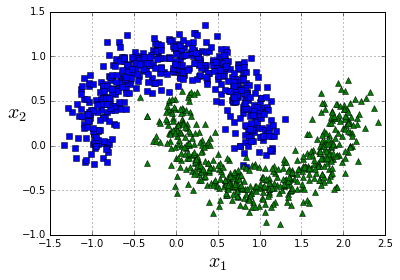

In [26]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X_moons, y_moons, [-1.5, 2.5, -1, 1.5])
plt.show()

In [27]:
y_moons.shape

(1000,)

In [28]:
nb_samples = X_moons.shape[0]
nb_inputs = X_moons.shape[1]
nb_outputs = 1

X_moons_with_bias = np.c_[np.ones((nb_samples, 1)), X_moons]
y_moons_column_vector = y_moons.reshape(-1, 1)

# setting aside test 
test_ratio = 0.2
test_size = int(nb_samples * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

nb_epoch = 10001
batch_size = int(np.ceil(nb_samples/20))
learning_rate = 0.1


In [29]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch


In [30]:
tf.reset_default_graph() # clear the graph

X = tf.placeholder(tf.float32, shape=(None, nb_inputs+1), name="X")
y = tf.placeholder(tf.float32, shape=(None, nb_outputs), name="X")
theta = tf.Variable(tf.random_uniform([nb_inputs + 1, nb_outputs], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = 1 / (1 + tf.exp(-logits)) 

epsilon = 1e-7  # to avoid an overflow when computing the log
#loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))
loss = tf.losses.log_loss(y, y_proba)  # uses epsilon = 1e-7 by default

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer() # need one again as we destroyed the graph
saver = tf.train.Saver()

In [31]:
# main training loop

nb_batch = int(np.ceil(X_train.shape[0]/batch_size))

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(nb_epoch):
        for i in range(nb_batch):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 1000 == 0:
            print("Epoch ", epoch, " - loss: ", loss_val)
    theta_best = theta.eval()
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch  0  - loss:  0.702397
Epoch  1000  - loss:  0.28795
Epoch  2000  - loss:  0.289449
Epoch  3000  - loss:  0.291067
Epoch  4000  - loss:  0.289189
Epoch  5000  - loss:  0.290856
Epoch  6000  - loss:  0.29104
Epoch  7000  - loss:  0.28863
Epoch  8000  - loss:  0.289938
Epoch  9000  - loss:  0.290031
Epoch  10000  - loss:  0.291152


In [32]:
theta_best

array([[ 0.76817799],
       [ 1.28483176],
       [-5.36563587]], dtype=float32)

In [33]:
y_pred = (y_proba_val >= 0.5)

In [34]:
y_pred

array([[ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [

In [35]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.84259259259259256

In [36]:
recall_score(y_test, y_pred)

0.91919191919191923

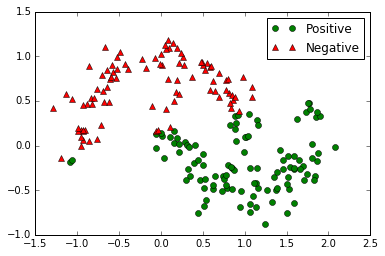

In [37]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

In [38]:
tf.reset_default_graph() # clear the graph

In [39]:


def logistic_regression(X, y, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            theta = tf.Variable(tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed), name="theta")
            logits = tf.matmul(X, theta, name="logits")
            #y_proba = 1 / (1 + tf.exp(-logits)) 
            y_proba = tf.sigmoid(logits)

        with tf.name_scope("learning"):
            loss = tf.losses.log_loss(y, y_proba)  # uses epsilon = 1e-7 by default
            loss_summary = tf.summary.scalar('log_loss', loss)
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
    
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    
    return y_proba, loss, training_op, loss_summary, init, saver

In [40]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [41]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

nb_inputs = X_train_enhanced.shape[1]

X = tf.placeholder(tf.float32, shape=(None, nb_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="X")

logdir = log_dir("logreg")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [42]:
import os.path

n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.447394
Epoch: 500 	Loss: 0.0622138
Epoch: 1000 	Loss: 0.0540065
Epoch: 1500 	Loss: 0.0514747
Epoch: 2000 	Loss: 0.0504649
Epoch: 2500 	Loss: 0.0498838
Epoch: 3000 	Loss: 0.0494936
Epoch: 3500 	Loss: 0.0492132
Epoch: 4000 	Loss: 0.0490353
Epoch: 4500 	Loss: 0.0489624
Epoch: 5000 	Loss: 0.0488937
Epoch: 5500 	Loss: 0.0488167
Epoch: 6000 	Loss: 0.0488199
Epoch: 6500 	Loss: 0.0487468
Epoch: 7000 	Loss: 0.0485081
Epoch: 7500 	Loss: 0.0487987
Epoch: 8000 	Loss: 0.0485909
Epoch: 8500 	Loss: 0.0486554
Epoch: 9000 	Loss: 0.0486459
Epoch: 9500 	Loss: 0.0485228
Epoch: 10000 	Loss: 0.0485228


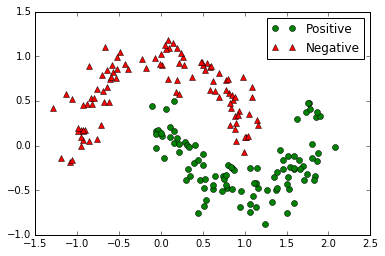

In [43]:
y_pred = (y_proba_val >= 0.5)
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()